# Import modules, libraries, and packages

In [110]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

# Get the current working directory of the notebook
current_dir = os.getcwd()
# Add the parent directory of the notebook to the Python path
root_dir = Path(current_dir).resolve().parents[2]
sys.path.append(root_dir)

import yaml
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters and constants

In [111]:
# Load config_file
with open('config_nh_run_plots.yml', 'r') as ymlfile:
        config_data = yaml.load(ymlfile, Loader=yaml.FullLoader)
        
data_dir = config_data['data_dir']
map_shape_file = os.path.join(data_dir, config_data['map_shape_file'])
hm_catchment = os.path.join(data_dir, config_data['hm_catchment'])
result_dir = Path(config_data['result_dir'])
result_file = config_data['result_file']
# Lower metrics4plotting
config_data['metrics4plotting'] = [metric.lower() for metric in config_data['metrics4plotting']]
metrics4plotting = config_data['metrics4plotting']

case_id = ('_').join(result_file.split('.')[0].split('_')[-2:])
# Lower metrics4table
config_data['metrics4table'] = [metric.lower() for metric in config_data['metrics4table']]

FILTER_BY_447 = 0
FILTER_BY_505 = 1
FILTER_BY_531 = 1

TRESHOLD_DICT = {
        'nse': 0.0,
        'kge': 0.0,
}

# Functions

In [112]:
def filter_basins(df, filter_by_447=FILTER_BY_447, filter_by_505=FILTER_BY_505, filter_by_531=FILTER_BY_531):
    '''
    Filter the dataframe to only include the 447 basins if filter_by_447 is True.
    Filter the dataframe to only include the 505 basins if filter_by_505 is True. - 423 basins
    Filter the dataframe to only include the 531 basins if filter_by_531 is True. - 423 basins
    '''
    if filter_by_447:
        # Load list of 447 basins
        basins447_dir = os.path.join('../../experiment_scripts', '447_basin_file.txt')
        with open(basins447_dir) as file:
            basin447 = [int(line.rstrip()) for line in file]
        # Filter the result dataframe to only include the 447 basins
        df = df[df['basin'].isin(basin447)]

    if filter_by_505 and len(df) == 531:
        # Load list of 505 basins
        basins505_dir = os.path.join('../../experiment_scripts', '505_basin_camels_spat_1989-2008_usa.txt')
        with open(basins505_dir) as file:
            basin505 = [int(line.rstrip()) for line in file]
        # Filter the result dataframe to only include the 505 basins
        df = df[df['basin'].isin(basin505)]

    if filter_by_531 and len(df) == 505:
        # Load list of 531 basins
        basins531_dir = os.path.join('../../experiment_scripts', '531_basin_file.txt')
        with open(basins531_dir) as file:
            basin531 = [int(line.rstrip()) for line in file]
        # Filter the result dataframe to only include the 531 basins
        df = df[df['basin'].isin(basin531)]

    return df

def plot_metric_map(df, states_reprojected, hm_catchment_gdf_reprojected, 
                    basin_coordinates_reprojected, metric='nse',
                    result_dir=Path('.'),
                    thresholds=TRESHOLD_DICT ):
    
    # Extract data given the metric
    df = df[['basin', metric]].copy()
    
    gap = 0.04  # Gap between the line and the text label - histogram
    
    threshold = thresholds.get(metric, None)  # Get the threshold for the given metric, default to 0.0

    # Define the colormap based on the metric values
    cmap = plt.cm.gnuplot
    if threshold is not None:
        normalize = mcolors.Normalize(threshold, vmax=1.0)  # Adjust vmax to 1.0
    else:
        normalize = mcolors.Normalize(vmin=df[metric].min(), vmax=df[metric].max())

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot USA map
    states_reprojected.boundary.plot(ax=ax, color=None, edgecolor='gray', linewidth=0.7)

    # Plot the catchments with colors based on the metric values
    hm_catchment_gdf_reprojected.boundary.plot(ax=ax, color=None, alpha=0, edgecolor='gray', linewidth=0)

    # Count how many in df[metric] are <= threshold
    if threshold is not None:
        nse_less_than_threshold = df[metric][df[metric] <= threshold].count()
        ax.set_title(f"{metric.upper()} results ({len(df)} basins | ${metric.upper()} \leq {threshold}$: {nse_less_than_threshold} counts)")
    else:
        ax.set_title(f"{metric.upper()} results ({len(df)} basins)")

    # Set entries to be the threshold value if they are less than the threshold
    if threshold is not None:
        df[metric] = df[metric].apply(lambda x: threshold if x <= threshold else x)

    # Plot circles located at reprojected basin coordinates with colors based on the metric values
    ax.scatter(basin_coordinates_reprojected.geometry.x, basin_coordinates_reprojected.geometry.y,
               s=42,  # size of the circles
               c=df[metric],  # color based on metric values
               cmap=cmap,  # colormap
               linewidth=0,  # width of circle edge
               alpha=0.7)  # transparency

    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Get rid of box lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Create an axis for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=-0.3)

    # Set the ticks on the colorbar
    if threshold is not None:
        cbar_ticks = np.linspace(threshold, df[metric].max(), num=5)
    else:
        cbar_ticks = np.linspace(df[metric].min(), df[metric].max(), num=5)
    cbar_ticks = np.round(cbar_ticks, 2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, ticks=cbar_ticks)

    # Add a histogram plot to the colorbar
    hist_values = df[metric].values
    hist_ax = divider.append_axes("right", size="10%", pad=0.6)  # adjust pad as needed

    n_bins = 20
    bins = np.linspace(hist_values.min(), hist_values.max(), n_bins + 1)

    hist_ax.hist(hist_values, bins=bins, orientation='horizontal', color='tab:blue', alpha=0.5)

    hist_ax.set_yticks([])  # remove y-ticks
    hist_ax.set_ylim(hist_values.min(), hist_values.max())  # set y-axis limits to match the data range
    # Adjust the x-ticks
    xticks = hist_ax.get_xticks()
    hist_ax.set_xticks(xticks[::3])  # set the x-ticks to every 3rd value
    hist_ax.set_xlim(0, hist_ax.get_xlim()[1])  # set the right limit to the maximum value
    # Move the x label to the top and adjust ticks
    hist_ax.set_xlabel('')
    hist_ax.xaxis.set_label_position('top')
    hist_ax.set_xlabel('Frequency', labelpad=10)
    hist_ax.xaxis.tick_top()
    hist_ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=False)
    # Get rid of box lines
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['bottom'].set_visible(False)
    hist_ax.spines['left'].set_visible(False)

    # Calculate the gap height based on the current ylim
    ylim = hist_ax.get_ylim()
    gap_height = gap * (ylim[1] - ylim[0])

    # Add mean and median value plots to the histogram
    mean_value = np.mean(hist_values)
    median_value = np.median(hist_values)
    max_value = max(mean_value, median_value)  # Find the greatest value

    # Plot mean value
    if mean_value < max_value:
        hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], mean_value - gap_height, f'Mean: {mean_value:.3f}', va='bottom', ha='right', color='tab:red')
    else:
        hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], mean_value + gap_height, f'Mean: {mean_value:.3f}', va='top', ha='right', color='tab:red')

    # Plot median value
    if median_value < max_value:
        hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], median_value - gap_height, f'Median: {median_value:.3f}', va='bottom', ha='right', color='green')
    else:
        hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], median_value + gap_height, f'Median: {median_value:.3f}', va='top', ha='right', color='green')

    # Show the plot
    plt.show()

    # Save the plot
    fig.savefig(result_dir / f'{metric}_basins_map.png', dpi=150, bbox_inches='tight')

# Load data

In [113]:
result_df = pd.read_csv(os.path.join(result_dir, result_file))

# Filter the result dataframe to only include the proper basins
result_df = filter_basins(result_df, 
                          filter_by_447=FILTER_BY_447, 
                          filter_by_505=FILTER_BY_505, 
                          filter_by_531=FILTER_BY_531)

# Select numeric columns
numeric_columns = result_df.select_dtypes(include=[np.number]).columns
# Eliminate rows with empty values in the numeric columns
result_df = result_df.dropna(subset=numeric_columns)

# Clean the basin ID by splitting the string and taking the last element - if the basin ID is string
if isinstance(result_df['basin'].values[0], str):
    result_df['basin'] = result_df['basin'].apply(lambda x: int(x.split('_')[-1]))

# Lower case the column names
result_df.columns = result_df.columns.str.lower()


In [114]:
# Load basin coordinates (hm_catchment)
hm_catchment_gdf = gpd.read_file(hm_catchment)

# Filter hm_catchment_gdf to only include the HRU_IDs in the hm_catchment['basin'] column
hm_catchment_gdf = hm_catchment_gdf[hm_catchment_gdf['hru_id'].isin(result_df['basin'])]
hm_catchment_gdf.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216..."
5,1052500,0.0,-71.17197,44.96168,3.961103e+08,646.073604,None,None,172588,"POLYGON ((-71.10862 45.12730, -71.10825 45.127..."
6,1054200,0.0,-71.05872,44.31072,1.813287e+08,629.165746,None,None,111995,"POLYGON ((-70.97999 44.39574, -70.97963 44.395..."


# Plot results

## Coordinates set up

In [115]:
# Define the CRS of your original data (if it's not already defined)
original_crs = 'EPSG:4326'  # Assuming WGS84 geographic CRS

states = gpd.read_file(map_shape_file)
# Set the CRS for the GeoDataFrame
states.crs = original_crs

# Define the new CRS you want to reproject to, for example, an Albers Equal Area projection
target_crs = 'ESRI:102008'  # ESRI:102008 is the WKID for the Albers Equal Area projection

# Reproject the GeoDataFrame
states_reprojected = states.to_crs(target_crs)

# Reproject the catchment GeoDataFrame
hm_catchment_gdf_reprojected = hm_catchment_gdf.to_crs(states_reprojected.crs)

# Reproject the coordinates of the circles
basin_coordinates_reprojected = gpd.points_from_xy(hm_catchment_gdf['lon_cen'], hm_catchment_gdf['lat_cen'], crs='EPSG:4326')
basin_coordinates_reprojected = gpd.GeoDataFrame(geometry=basin_coordinates_reprojected, crs='EPSG:4326')
basin_coordinates_reprojected = basin_coordinates_reprojected.to_crs(states_reprojected.crs)

In [116]:
result_df.head()

,basin,nse,alpha-nse,beta-nse,fhv,fms,flv,kge,beta-kge,peak-timing,peak-mape,pearson-r
1,1022500,0.842020,0.887704,-0.083235,-10.934262,-4.603954,29.901701,0.835306,0.908168,0.173913,26.213638,0.922022
3,1031500,0.876689,0.834055,-0.009496,-16.858105,-14.577388,58.606051,0.823792,0.985116,0.181818,29.110635,0.942639
4,1047000,0.845221,0.846470,-0.012514,-17.051159,-3.587646,28.352291,0.826988,0.980786,0.090909,29.625320,0.922590
5,1052500,0.814879,0.780061,0.032017,-22.639836,-19.497199,41.466976,0.758107,1.050701,0.045455,30.506721,0.913005
6,1054200,0.704545,0.703759,0.012045,-31.582111,-13.539003,30.949499,0.668211,1.024101,0.272727,47.251424,0.852541


## CDF

In [117]:
folder4cdf_dir_list = config_data['folders4cdf_dir']

In [118]:
folder4cdf_dir_list

[{'directory': 'runs_531_nh_paper',
  'experiment': 'E0a (LSTM: 531/5)',
  'color': 'red',
  'marker': 'o',
  'linestyle': '--'},
 {'directory': 'runs_505_nh_paper_camelsspat_emearth',
  'experiment': 'E0b (LSTM: 505/5)',
  'color': 'blue',
  'marker': 'o',
  'linestyle': '--'},
 {'directory': 'runs_505_nh_paper_camelsspat_17inp',
  'experiment': 'E0c (LSTM: 505/17)',
  'color': 'green',
  'marker': 'o',
  'linestyle': '--'},
 {'directory': 'runs_531_nh_paper_ealstm',
  'experiment': 'E1a (EA-LSTM: 531/5+27)',
  'color': 'purple',
  'marker': 's',
  'linestyle': '-'},
 {'directory': 'runs_505_nh_paper_camelsspat_ealstm15static',
  'experiment': 'Eab (EA-LSTM: 505/5+15)',
  'color': 'orange',
  'marker': 's',
  'linestyle': '-'}]

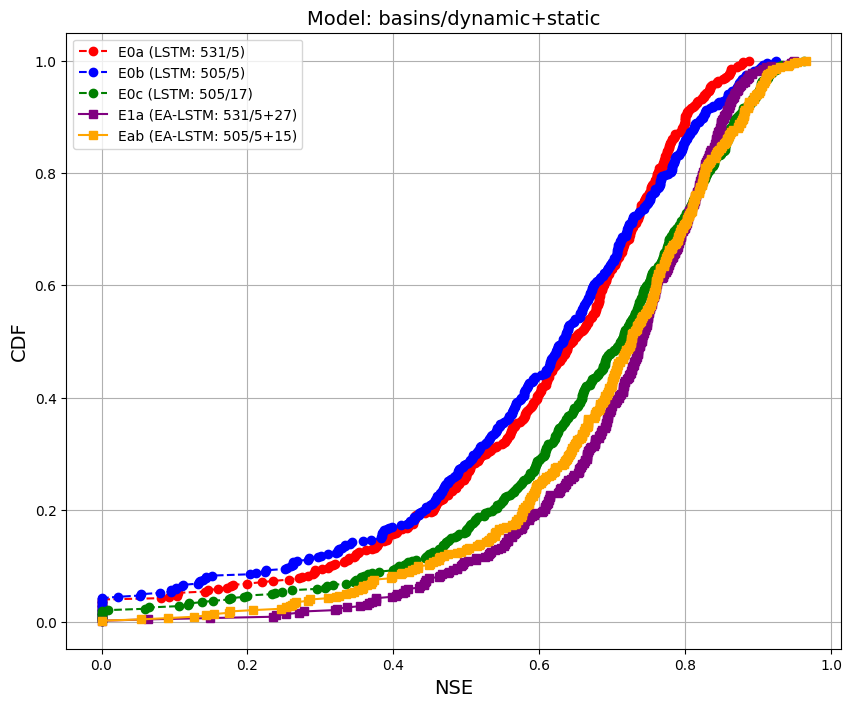

In [119]:
folder4cdf_dir_list = config_data['folders4cdf_dir']

plt.figure(figsize=(10, 8))
for folder in folder4cdf_dir_list:
        
#   - directory: runs_531_nh_paper
#     experiment: E0a (531/5)
#     color: red
#     marker: o
    folder_dir = Path(folder['directory'])
    folder_exp = folder['experiment']
    folder_color = folder['color']
    folder_marker = folder['marker']
    folder_line = folder['linestyle']


    # Load the result dataframe
    df = pd.read_csv(folder_dir / 'test_ensemble_metrics.csv')

    # Make negative NSE values zero
    df['NSE'] = df['NSE'].apply(lambda x: 0 if x < 0 else x)

    # Filter the result dataframe to only include the proper basins
    df = filter_basins(df, 
                        filter_by_447=FILTER_BY_447, 
                        filter_by_505=FILTER_BY_505, 
                        filter_by_531=FILTER_BY_531)
    # Select basin and NSE columns
    df = df[['basin', 'NSE']].copy()
    # Sort NSE values
    nse_values = np.sort(df['NSE'])
    # Calculate cumulative probabilities
    cdf = np.arange(1, len(nse_values) + 1) / len(nse_values)
    # Plot the CDF
    plt.plot(nse_values, cdf, color=folder_color, marker=folder_marker, linestyle=folder_line, label=folder_exp)

plt.xlabel('NSE', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.title('Model: basins/dynamic+static', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

## Metrics-Map

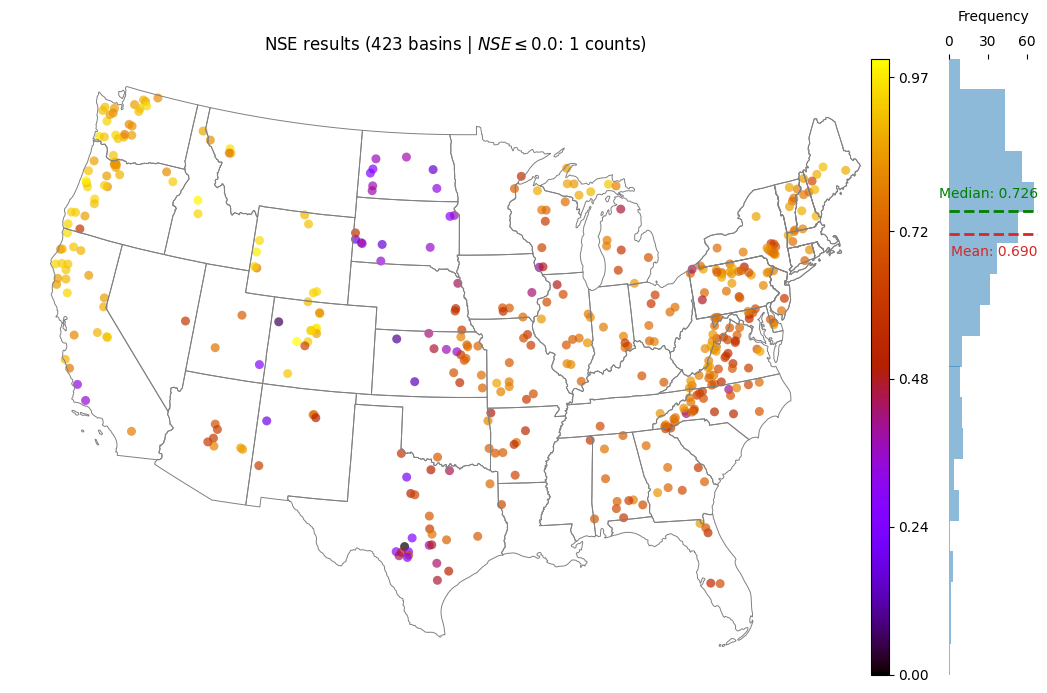

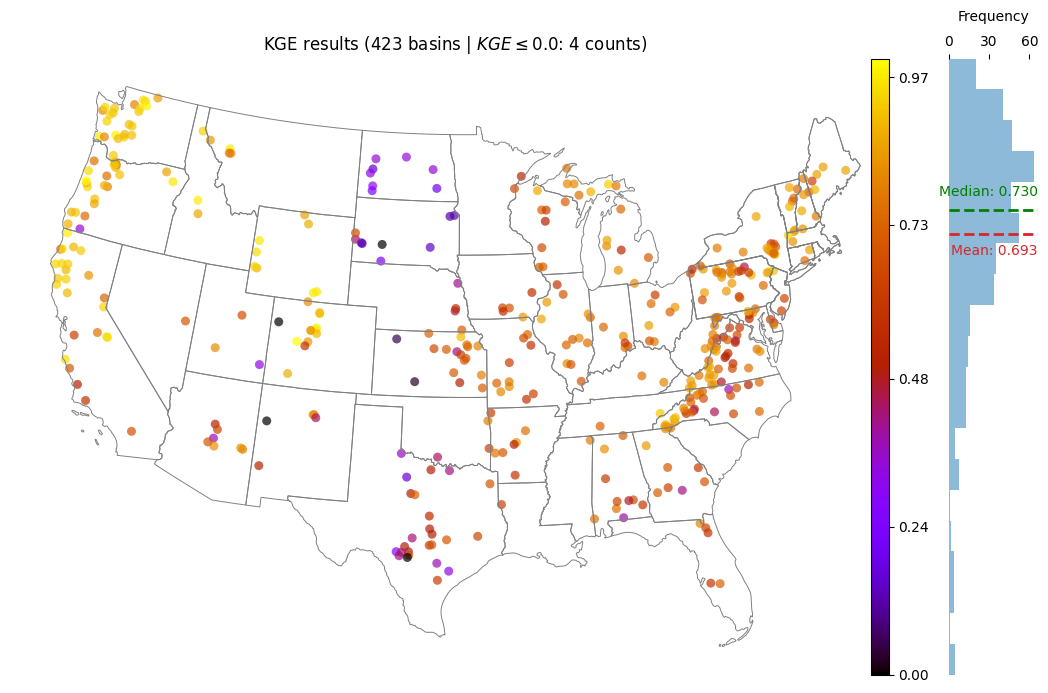

In [103]:
for metric in metrics4plotting:
    plot_metric_map(result_df, states_reprojected, hm_catchment_gdf_reprojected, 
                    basin_coordinates_reprojected, 
                    metric=metric, 
                    result_dir=result_dir,
                    thresholds=TRESHOLD_DICT)

# Tables

In [104]:
# Read the CSV files
data = {}
for file_name in config_data['files4table']:
    df = pd.read_csv(os.path.join(result_dir, file_name))

    # Filter the result dataframe to only include the proper basins
    data[file_name] = filter_basins(df, 
                                    filter_by_447=FILTER_BY_447, 
                                    filter_by_505=FILTER_BY_505, 
                                    filter_by_531=FILTER_BY_531)

    # print(f"Loaded {file_name} with {data[file_name].shape[0]} rows")
    # display(data[file_name].head())
    
# Initialize an empty dictionary to store statistics
statistics = {}

# Calculate statistics for each model
for file_name, df in data.items():
    
    # Lowercase the column names
    df.columns = df.columns.str.lower() 
    # '_' to '-' in column names
    df.columns = df.columns.str.replace('_', '-') 
    
    case_id = ('_').join(file_name.split('.')[0].split('_')[-2:])
    
    # If NSE is in the columns, count the number of basins with NSE < 0 and exclude those rows after
    if 'nse' in df.columns:
        n_basins_nse_lt_0 = df[df['nse'] <= 0].shape[0]
        # Set negative NSE values to 0
        df['nse'] = df['nse'].apply(lambda x: 0 if x < 0 else x)
        median = df['nse'].median()
        mean = df['nse'].mean()
        statistics[case_id] = {'nse': {
            'median': median,
            'mean': mean,
        }}
        statistics[case_id]['n_basins_nse_lt_0'] = n_basins_nse_lt_0
    
    # For each metric, find median- for NSE calculate mean, and number of basins with NSE < 0 (exclude those from all the statistics)
    for met in config_data['metrics4table']:
        
        met = met.lower()
        # Compute the statistics
        if met != 'nse':
            median = df[met].median()
            statistics[case_id][met] = {
                'median': median,
            }

# Create DataFrame from statistics dictionary
df_statistics = pd.DataFrame(statistics).transpose()

In [105]:
# Convert data to DataFrame
df_statistics = pd.DataFrame(statistics).T

# Convert nested dictionaries to individual columns
df_statistics['nse_mean'] = df_statistics['nse'].apply(lambda x: round(x['mean'], 3))
df_statistics['nse_median'] = df_statistics['nse'].apply(lambda x: round(x['median'], 3))
df_statistics['n_basins_nse_lt_0_count'] = df_statistics['n_basins_nse_lt_0']
df_statistics['alpha-nse_median'] = df_statistics['alpha-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['beta-nse_median'] = df_statistics['beta-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['fhv_median'] = df_statistics['fhv'].apply(lambda x: round(x['median'], 1))
df_statistics['fms_median'] = df_statistics['fms'].apply(lambda x: round(x['median'], 1))
df_statistics['flv_median'] = df_statistics['flv'].apply(lambda x: round(x['median'], 1))

# Drop unnecessary columns
df_statistics.drop(columns=['nse', 'n_basins_nse_lt_0', 'alpha-nse', 'beta-nse', 'fhv', 'fms', 'flv'], inplace=True)

# Ensure the 'n_basins_nse_lt_0_count' column is numeric
df_statistics['n_basins_nse_lt_0_count'] = pd.to_numeric(df_statistics['n_basins_nse_lt_0_count'])

# Ensure only numerical columns are selected for mean calculation
numeric_cols = df_statistics.select_dtypes(include=['float64', 'int']).columns

# Add a row for the mean values of the statistics
mean_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].mean()
# Round the mean values to 3 decimal places
mean_values = mean_values.round(3)

# Create a new DataFrame for the mean values
df_mean = pd.DataFrame(mean_values).transpose()
df_mean.index = ['seeds_mean']

# Add the std values to the DataFrame
std_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].std()
# Round the std values to 3 decimal places
std_values = std_values.round(3)

# Create a new DataFrame for the std values
df_std = pd.DataFrame(std_values).transpose()
df_std.index = ['seeds_std']

# Insert the mean row before the 'ensemble_metrics' row
idx = df_statistics.index.get_loc('ensemble_metrics')
df_statistics = pd.concat([df_statistics.iloc[:idx], df_mean, df_std, df_statistics.iloc[idx:]])

display(df_statistics)

# Convert DataFrame to LaTeX table format
latex_table = df_statistics.to_latex(
    index=True,
    header=True,
    float_format="%.3f"
)

print(latex_table)

,nse_mean,nse_median,n_basins_nse_lt_0_count,alpha-nse_median,beta-nse_median,fhv_median,fms_median,flv_median
111,0.660,0.700,8.000,0.848,-0.022,-15.00,-11.500,11.300
222,0.656,0.696,7.000,0.847,-0.014,-13.90,-15.500,16.200
333,0.657,0.699,0.000,0.823,-0.021,-16.00,-12.900,22.800
444,0.663,0.702,5.000,0.843,-0.020,-14.20,-12.800,16.200
555,0.666,0.709,4.000,0.853,-0.013,-13.00,-14.000,9.200
666,0.665,0.707,4.000,0.841,-0.010,-15.20,-10.700,7.600
777,0.667,0.707,6.000,0.852,-0.017,-14.20,-11.300,-2.600
888,0.668,0.698,3.000,0.838,-0.015,-14.90,-15.200,22.100
seeds_mean,0.663,0.702,4.625,0.843,-0.016,-14.55,-12.988,12.850
seeds_std,0.005,0.005,2.504,0.010,0.004,0.92,1.796,8.358


\begin{tabular}{lrrrrrrrr}
\toprule
 & nse_mean & nse_median & n_basins_nse_lt_0_count & alpha-nse_median & beta-nse_median & fhv_median & fms_median & flv_median \\
\midrule
111 & 0.660 & 0.700 & 8.000 & 0.848 & -0.022 & -15.000 & -11.500 & 11.300 \\
222 & 0.656 & 0.696 & 7.000 & 0.847 & -0.014 & -13.900 & -15.500 & 16.200 \\
333 & 0.657 & 0.699 & 0.000 & 0.823 & -0.021 & -16.000 & -12.900 & 22.800 \\
444 & 0.663 & 0.702 & 5.000 & 0.843 & -0.020 & -14.200 & -12.800 & 16.200 \\
555 & 0.666 & 0.709 & 4.000 & 0.853 & -0.013 & -13.000 & -14.000 & 9.200 \\
666 & 0.665 & 0.707 & 4.000 & 0.841 & -0.010 & -15.200 & -10.700 & 7.600 \\
777 & 0.667 & 0.707 & 6.000 & 0.852 & -0.017 & -14.200 & -11.300 & -2.600 \\
888 & 0.668 & 0.698 & 3.000 & 0.838 & -0.015 & -14.900 & -15.200 & 22.100 \\
seeds_mean & 0.663 & 0.702 & 4.625 & 0.843 & -0.016 & -14.550 & -12.988 & 12.850 \\
seeds_std & 0.005 & 0.005 & 2.504 & 0.010 & 0.004 & 0.920 & 1.796 & 8.358 \\
ensemble_metrics & 0.690 & 0.726 & 1.000 & 0.826 &